In [12]:
import state_space_system
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import numpy as np
from casadi import *

from ERA import *
from kalman_filter import *
from utils_optimization_problem import *

mpl.rcParams['font.size'] = 16 # set the matplotlib parameter

In [13]:
## system identification ##

q = 2   # Number of inputs
p = 3   # Number of outputs
r = 10  # Reduced model order

time = np.linspace(0, 20, num=500)
sys = state_space_system.sys()# import real system
sys.reset()
u = np.zeros((time.shape[0]-1, 2))
u[0,0] = 1
u1 = u

u = np.zeros((time.shape[0]-1, 2))
u[0,1] = 1
u2 = u

re = 10 # repeated time for measurement
y_1 = np.zeros((time.shape[0],3))
y_2 = np.zeros((time.shape[0],3))
for n in range(re):
    y_1_t = sys.simulate(time, u1)
    # Concatenate:
    y_1_t = np.array(y_1_t)
    y_1 += y_1_t

    y_2_t = sys.simulate(time, u2)
    # Concatenate:
    y_2_t = np.array(y_2_t)
    y_2 += y_2_t
y_1 /= re
y_2 /= re
    
yFull = np.zeros((time.shape[0],p,q))

yFull[:,:,0] = y_1[:,:]
yFull[:,:,1] = y_2[:,:]

YY = np.transpose(yFull,axes=(1,2,0)) # reorder to size p x q x m 

# Compute reduced order model from impulse response
mco = int(np.floor((yFull.shape[0]-1)/2)) # m_c = m_o = (m-1)/2
Ar,Br,Cr,Dr,HSVs = ERA(YY,mco,mco,q,p,r)

In [14]:
## Augmented system ##
Ab,Bb,Cb = augmented_system(Ar,Br,Cr)

nx = Ab.shape[1] #set the number of state and the control inputs
nu = Bb.shape[1]
ny = Cb.shape[0]

In [15]:
## create a symbolic expression of state space ##
x = SX.sym("x",nx,1)
delta_u = SX.sym("delta_u",nu,1)

x_next = Ab@x + Bb@delta_u
system = Function("sys",[x,delta_u],[x_next]) # Create the CasADi function

In [16]:
## MPC initialization and casadi objective function ##

Q = 30                    # make it larger to get a more aggresive controller
Q = Q*np.diag(np.ones(ny)) # the state cost mutiplyer by using the output channel: ny=3
S = Q # S for terminal cost is equal to Q

R = 10                     # set it to 1, trying to reduce the influence from the control energy term
R = np.diag(R*np.ones(nu)) # the cost of control

N = 15                     # horizon

y_Ref = SX.sym("y_ref",ny,1)   # desired trajectory

# state cost
stage_cost = (y_Ref-Cb@x).T@Q@(y_Ref-Cb@x)+ delta_u.T@R@delta_u
stage_cost_fcn = Function('stage_cost',[x,delta_u,y_Ref],[stage_cost])

# terminal cost
terminal_cost = (y_Ref-Cb@x).T@S@(y_Ref-Cb@x)
terminal_cost_fcn = Function('terminal_cost',[x,y_Ref],[terminal_cost])

In [17]:
# state constraints
lb_x = -10*np.ones((nx,1))
ub_x = 10*np.ones((nx,1))
# the last two state variables is actually the control inputs
lb_x[nx-nu:] = -5
ub_x[nx-nu:] = 5
# input changes constraints
lb_u = -2*np.ones((nu,1))
ub_u = 2*np.ones((nu,1))

In [18]:
## create optimization problem ##
def casadi_setting(reference_signal,nx,nu): # reference_signal:3*15 output*horizon
    
    X = SX.sym("X",(N+1)*nx,1)
    delta_U = SX.sym("U",N*nu,1)

    J = 0
    lb_X = [] # lower bound for X.
    ub_X = [] # upper bound for X
    lb_U = [] # lower bound for delta_U
    ub_U = [] # upper bound for delta_U
    g = []    # constraint expression g
    lb_g = []  # lower bound for constraint expression g
    ub_g = []  # upper bound for constraint expression g
    
    for k in range(N):
        # 01 
        x_k = X[k*nx:(k+1)*nx,:]
        x_k_next = X[(k+1)*nx:(k+2)*nx,:]
        u_k = delta_U[k*nu:(k+1)*nu,:]
        # 01

        # 02 
        # objective
        J += stage_cost_fcn(x_k,u_k,reference_signal[k])
        # 02

        # 03 
        # equality constraints (system equation)
        x_k_next_calc = system(x_k,u_k)
        # 03

        # 04
        g.append(x_k_next - x_k_next_calc)
        lb_g.append(np.zeros((nx,1)))
        ub_g.append(np.zeros((nx,1)))
        # 04

        # 05
        lb_X.append(lb_x)
        ub_X.append(ub_x)
        lb_U.append(lb_u)
        ub_U.append(ub_u)
        # 05


    x_terminal = X[N*nx:(N+1)*nx,:]
    J += terminal_cost_fcn(x_terminal,reference_signal[-1])
    lb_X.append(lb_x)
    ub_X.append(ub_x)
    return lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J



This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

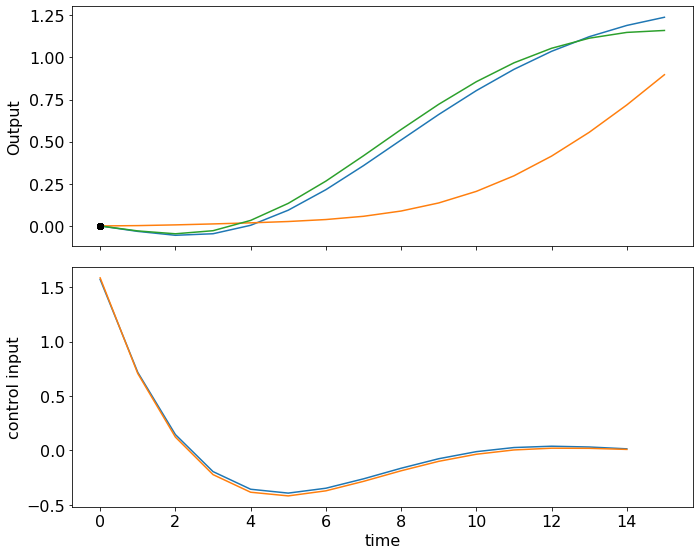

In [19]:
## test the functional solver production ##
reference = np.ones((N,ny))
lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J = casadi_setting(reference,nx,nu)
# Casadi solver
lbx = vertcat(*lb_X, *lb_U)
ubx = vertcat(*ub_X, *ub_U)
x = vertcat(X,delta_U)
g = vertcat(*g)
lbg = vertcat(*lb_g)
ubg = vertcat(*ub_g)

prob = {'f':J,'x':x,'g':g}
solver = nlpsol('solver','ipopt',prob)

x_0 = np.zeros((nx,1))

lbx[:nx]=x_0
ubx[:nx]=x_0

res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)

X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
delta_U = res['x'][(N+1)*nx:].full().reshape(N, nu)
Y = np.zeros((ny,1))

for n in range(N):
    temp = X[n+1].reshape(nx,1)
    Y = np.hstack((Y,Cb@temp))
    

# visulization of the result
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(Y.T)
ax[1].plot(delta_U)
ax[0].set_ylabel('Output')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

# Highlight the selected initial state (the lines should start here!)
ax[0].plot(0,x_0.T, 'o', color='black')

fig.align_ylabels()
fig.tight_layout()

## test result looks pretty good

In [20]:
N_sim = 500 # total simulation step
#################################### compensate for the last time step for 13 units shape:(3, 513)
REFERENCE = np.ones((ny,N_sim+13))
#################################### reference change test

In [21]:
## MPC main loop ##
x_0 = np.zeros((nx,1))
res_x = [x_0]
res_delta_u = []
res_u = []

## original system measurement initialization
sys.reset()
y_res = [sys.make_measurement()]

## kalman filter parameters
P_k = np.eye(Ab.shape[0],Ab.shape[1])
Q_k = np.ones((Ab.shape[0],Ab.shape[1]))
R_k = np.eye(Cb.shape[0],Cb.shape[0])

X = []

for i in range(N_sim-1):
    
    reference = REFERENCE[:,i:i+N]
    
    lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J = casadi_setting(reference.T,nx,nu)
    
    # Casadi solver
    lbx = vertcat(*lb_X, *lb_U)
    ubx = vertcat(*ub_X, *ub_U)
    x = vertcat(X,delta_U)
    g = vertcat(*g)
    lbg = vertcat(*lb_g)
    ubg = vertcat(*ub_g)

    prob = {'f':J,'x':x,'g':g}
    solver = nlpsol('solver','ipopt',prob)
    
    lbx[:nx]=x_0
    ubx[:nx]=x_0
    
    # solving the optimization problem
    res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)
    delta_u_k = res['x'][(N+1)*nx:(N+1)*nx+nu,:].full()
    
    X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
    u_st = X[0,10:].reshape(nu,1)+ delta_u_k
    res_u.append(u_st)
    # simulate the system
    sys.simulate(time[i:i+2], (np.array(u_st)).reshape(1,2))
    
    # Append new measurement
    y_res.append(sys.make_measurement())
    
    # state Estimation
    xpred, Ppred = predict(x_0, (np.array(delta_u_k)).reshape(Bb.shape[1],1), P_k, Ab, Q_k, Bb)
    K = K_G(P_k,Cb,R_k)
    x_next,P_k = update(xpred,K,y_res[i+1],Cb,P_k,R_k,Ab)
    
    res_x.append(x_next)
    x_0 = x_next

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   7 1.1612303e+001 2.66e-015 9.15e-015  -8.6 8.39e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.1612302730337158e+001   1.1612302730337158e+001
Dual infeasibility......:  9.1455109226837533e-015   9.1455109226837533e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5061564211099140e-009   2.5061564211099140e-009
Overall NLP error.......:  2.5061564211099140e-009   2.5061564211099140e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   3 1.2619869e+000 1.33e-015 6.27e-015  -1.7 3.80e-001    -  1.00e+000 1.00e+000f  1
   4 1.2612378e+000 2.66e-015 7.38e-015  -2.5 3.00e-002    -  1.00e+000 1.00e+000f  1
   5 1.2612358e+000 3.55e-015 7.00e-015  -3.8 1.54e-003    -  1.00e+000 1.00e+000f  1
   6 1.2612358e+000 3.55e-015 6.56e-015  -5.7 7.63e-005    -  1.00e+000 1.00e+000h  1
   7 1.2612358e+000 3.55e-015 6.07e-015  -8.6 9.38e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.2612357960490190e+000   1.2612357960490190e+000
Dual infeasibility......:  6.0655179937653029e-015   6.0655179937653029e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5062149325559037e-009   2.5062149325559037e-009
Overall NLP error.......:  2.5062149325559037e-009   2.5062149325559037e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   2 1.7810941e+000 2.66e-015 2.75e-002  -1.0 9.99e-001    -  9.53e-001 1.00e+000f  1
   3 1.6574696e+000 2.66e-015 7.80e-015  -1.7 3.75e-001    -  1.00e+000 1.00e+000f  1
   4 1.6567571e+000 2.66e-015 6.63e-015  -2.5 2.92e-002    -  1.00e+000 1.00e+000f  1
   5 1.6567551e+000 2.66e-015 5.54e-015  -3.8 1.50e-003    -  1.00e+000 1.00e+000f  1
   6 1.6567551e+000 2.66e-015 7.01e-015  -5.7 7.48e-005    -  1.00e+000 1.00e+000h  1
   7 1.6567551e+000 2.66e-015 5.31e-015  -8.6 9.19e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.6567551329018524e+000   1.6567551329018524e+000
Dual infeasibility......:  5.3080471869196793e-015   5.3080471869196793e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5062093686778217e-009   2.5062093686778217e-009
Overall NLP error.......:  2.5062093686778217e-009   2.5062093686778217e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3500455e+003 4.39e+000 1.10e+001  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3500578e+003 4.33e+000 1.10e+001  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3501466e+003 4.34e+000 1.10e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.7585846e+000 1.78e-015 2.63e-001  -1.0 4.32e+000    -  6.96e-001 1.00e+000f  1
   2 1.3347657e+000 1.78e-015 2.71e-002  -1.0 1.00e+000    -  9.54e-001 1.00e+000f  1
   3 1.2116888e+000 1.78e-015 9.78e-015  -1.7 3.74e-001    -  1.00e+000 1.00e+000f  1
   4 1.2109864e+000 2.66e-015 6.51e-015  -2.5 2.90e-002    -  

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3501398e+003 4.32e+000 1.10e+001  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   4 1.5319299e+000 2.66e-015 9.25e-015  -2.5 2.89e-002    -  1.00e+000 1.00e+000f  1
   5 1.5319279e+000 2.66e-015 8.66e-015  -3.8 1.49e-003    -  1.00e+000 1.00e+000f  1
   6 1.5319279e+000 2.66e-015 5.65e-015  -5.7 7.41e-005    -  1.00e+000 1.00e+000h  1
   7 1.5319279e+000 3.55e-015 8.89e-015  -8.6 9.11e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.5319279453600503e+000   1.5319279453600503e+000
Dual infeasibility......:  8.8870670885537182e-015   8.8870670885537182e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5062081088832014e-009   2.5062081088832014e-009
Overall NLP error.......:  2.5062081088832014e-009   2.5062081088832014e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3500439e+003 4.33e+000 1.10e+001  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1


Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0340979961879915e+000   1.0340979961879915e+000
Dual infeasibility......:  8.5985992716357479e-015   8.5985992716357479e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5062103343770827e-009   2.5062103343770827e-009
Overall NLP error.......:  2.5062103343770827e-009   2.5062103343770827e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.012
Total CPU secs in NLP function evaluations     

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3500637e+003 4.34e+000 1.10e+001  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   7 1.1352854e+000 2.66e-015 5.05e-015  -8.6 9.19e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.1352853679741550e+000   1.1352853679741550e+000
Dual infeasibility......:  5.0503318275940624e-015   5.0503318275940624e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5062098325777732e-009   2.5062098325777732e-009
Overall NLP error.......:  2.5062098325777732e-009   2.5062098325777732e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3501068e+003 4.35e+000 1.10e+001  -1.0 0.00e+000    -  0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3500931e+003 4.33e+000 1.10e+001  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

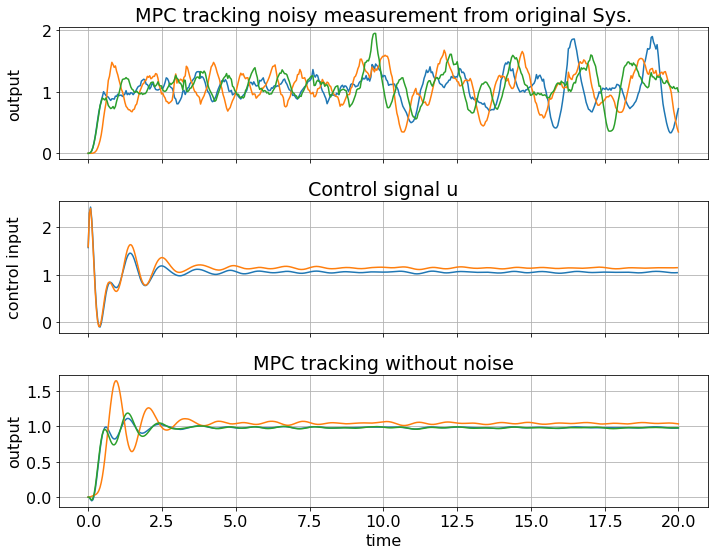

In [22]:
## results visualization ##
time = np.linspace(0, 20, num=500)

res_x_T = np.concatenate(res_x,axis=1)
res_u = np.array(res_u)
res_u = res_u.reshape(time.shape[0]-1,nu)

res_y = np.array(y_res)

y0 = np.zeros((ny,1))
res_y_withoutnoise = [y0]
for n in range(len(time)-1):
    temp = (Cb@res_x_T[:,n]).reshape(Cb.shape[0],1) + (Dr@res_u[n,:]).reshape(Cb.shape[0],1)
    res_y_withoutnoise.append(temp)
res_y_withoutnoise = np.array(res_y_withoutnoise).reshape(len(time),Cb.shape[0])


fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ax[0].plot(time,res_y)
ax[0].set_title('MPC tracking noisy measurement from original Sys.')
ax[0].set_ylabel('output')
ax[0].grid()

ax[1].set_title('Control signal u')
ax[1].plot(time[:-1],res_u)
ax[1].set_ylabel('control input')
ax[1].grid()

ax[2].plot(time,res_y_withoutnoise)
ax[2].set_title('MPC tracking without noise')
ax[2].set_xlabel('time')
ax[2].set_ylabel('output')
ax[2].grid()

fig.align_ylabels()
fig.tight_layout()

plt.savefig('Step_response',dpi=250)